In [2]:
from PIL import Image, ImageFilter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [3]:
def points_from_img(img_file, min_distance=5):
    """
    Returns a list of (x, y) tuples of the pixel coordinates 
    for the outline of the image, ensuring that no two points are too close to each other.
    
    :param img_file: Path to the image file.
    :param min_distance: Minimum distance between consecutive points.
    """
    # Open the image file
    img = Image.open(img_file).convert("L")  # Convert to grayscale
    # Apply edge detection filter
    img = img.filter(ImageFilter.FIND_EDGES)
    
    # Initialize a list to store the coordinates
    points = []
    last_point = None  # Track the last point added
    
    # Iterate over each pixel
    for y in range(img.height):
        for x in range(img.width):
            # Get the value of the pixel
            pixel = img.getpixel((x, y))
            # If the pixel is not black, it is part of the outline
            if pixel != 0:
                current_point = (x, y)
                # Check if it's the first point or if it's sufficiently far from the last added point
                if last_point is None or np.linalg.norm(np.array(current_point) - np.array(last_point)) >= min_distance:
                    points.append(current_point)
                    last_point = current_point  # Update the last point added
    # Normalize the points
    points = np.array(points)
    mean = np.mean(points, axis=0)
    normalized_points = points - mean
    
    return normalized_points.tolist()

In [4]:
def plot_points(all_points, plot_titles=None, highlight_index=None):
    """
    Plots multiple sets of points side by side using seaborn.
    Each set of points should be a 2D numpy array where each row is [x, y].
    An optional list of highlight_indices can be passed to color specific points differently in each set.
    
    :param points_list: List of 2D numpy arrays of points.
    :param plot_titles: List of titles for each subplot.
    :param highlight_indices: List of indices of the points to highlight in each set.
    """
    # If only a single point, turn it into a list
    if not isinstance(all_points, list):
        points_list = [all_points]
    else:
        points_list = all_points
    # Number of plots
    num_plots = len(points_list)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))
    
    # If there's only one plot, wrap axes in a list
    if num_plots == 1:
        axes = [axes]
    
    # Loop through each set of points and corresponding axis
    for idx, (points, ax) in enumerate(zip(points_list, axes)):
        # Ensure points is a numpy array
        points = np.array(points.cpu())
        
        # Extract x and y coordinates
        x = points[:, 0]
        y = points[:, 1]
        
        # Create a hue array, default hue is 'Normal'
        hues = ['Normal'] * len(points)
        
        # If highlight_indices is provided and valid, change the hue of the specified point
        if highlight_index and highlight_index < len(points):
            hues[highlight_index] = 'Highlight'  # Highlight category
        
        # Define a custom palette
        palette = {'Normal': 'blue', 'Highlight': 'red'}
        
        # Create a scatter plot on the specified axis
        sns.scatterplot(x=x, y=y, hue=hues, palette=palette, legend=None, ax=ax)
        ax.invert_yaxis()  # Invert y-axis to match image coordinates
        
        # Set title for each subplot
        if plot_titles and idx < len(plot_titles):
            ax.set_title(plot_titles[idx])
        else:
            ax.set_title(f"Plot {idx + 1}")  # Default title if no custom title provided
    
    plt.tight_layout()
    plt.show()

In [5]:
points = points_from_img("../data/p2ch10/pytorch_logo.png")
# inspect the first 3 points
for x, y in points[:3]:
    print(f"({x:.3f}, {y:.3f})")
x0 = torch.tensor(points, dtype=torch.float32)
x0.shape

(4.310, -479.528)
(0.310, -475.528)
(4.310, -472.528)


torch.Size([3177, 2])

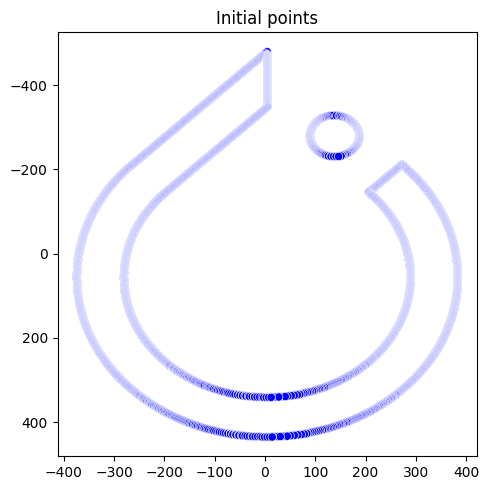

In [6]:
plot_points(x0, ["Initial points"])

In [7]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)
T = 1000
betas = linear_beta_schedule(T)
print(betas[0], betas[10], betas[T-1])

tensor(1.0000e-04) tensor(0.0003) tensor(0.0200)


In [8]:
def diffuse_points(points, beta):
    # Tensor with random numbers from a normal distribution of mean 0 and variance 1
    new_mean = torch.sqrt(1 - beta) * points
    noise = torch.randn(points.shape)
    perturbation = torch.sqrt(beta) * noise
    points = new_mean + perturbation
    return points, noise

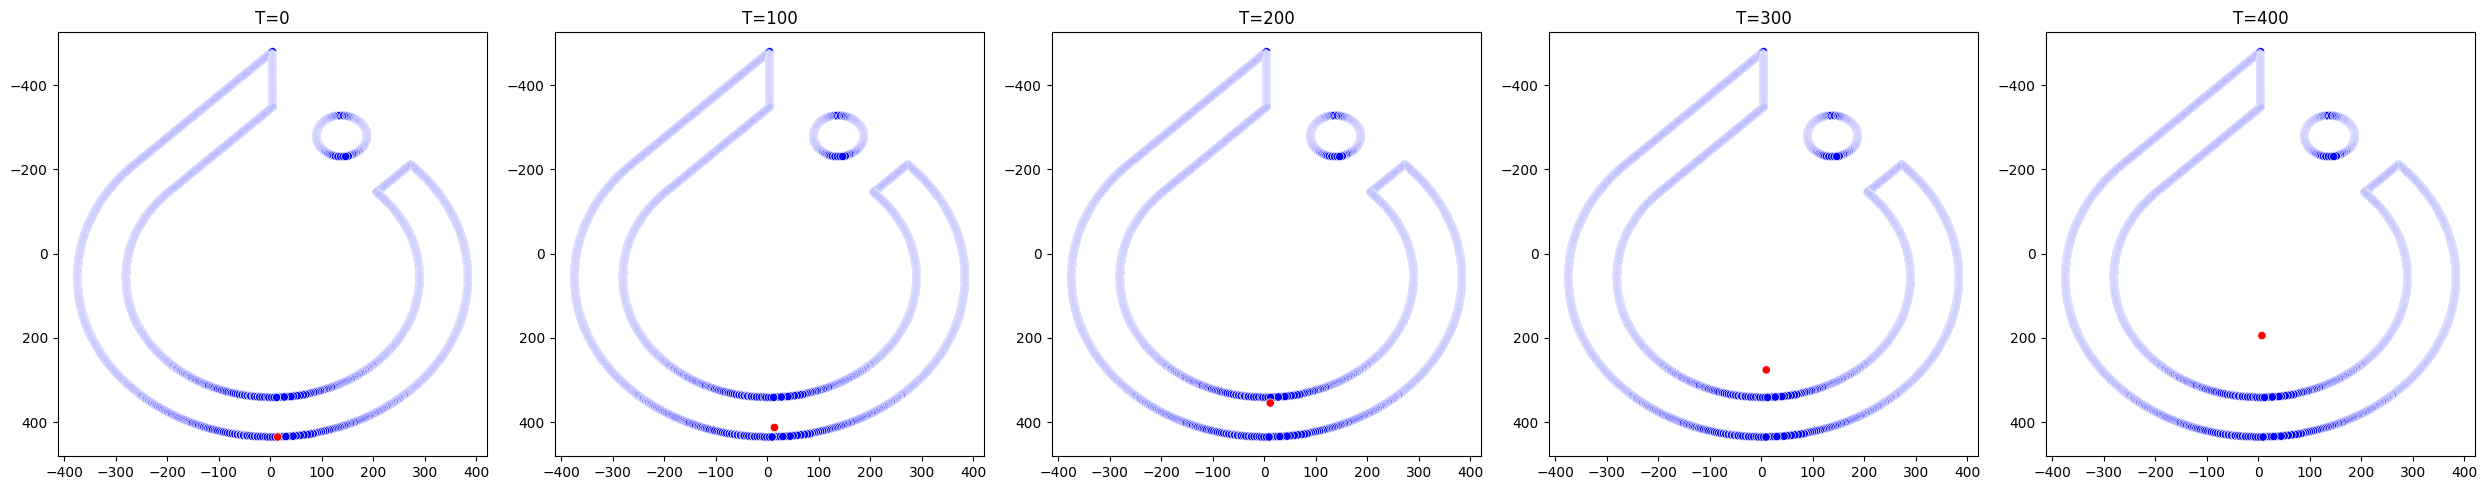

In [9]:
temp_x0 = x0.clone()
index = len(temp_x0) - 1
single_point = temp_x0[index]
all_points = []
for i in range(500):
    if i % 100 == 0:
        temp_x0[index] = single_point
        all_points.append(temp_x0.clone())
    single_point, _ = diffuse_points(single_point, betas[i])

plot_points(all_points, ["T=0", "T=100", "T=200", "T=300", "T=400"], highlight_index=index)

In [10]:
x = torch.zeros(T, *x0.shape)
x[0] = x0
for t in range(1, T):
    beta_t = betas[t]
    x_t, noise = diffuse_points(x[t - 1], beta_t)
    x[t] = x_t

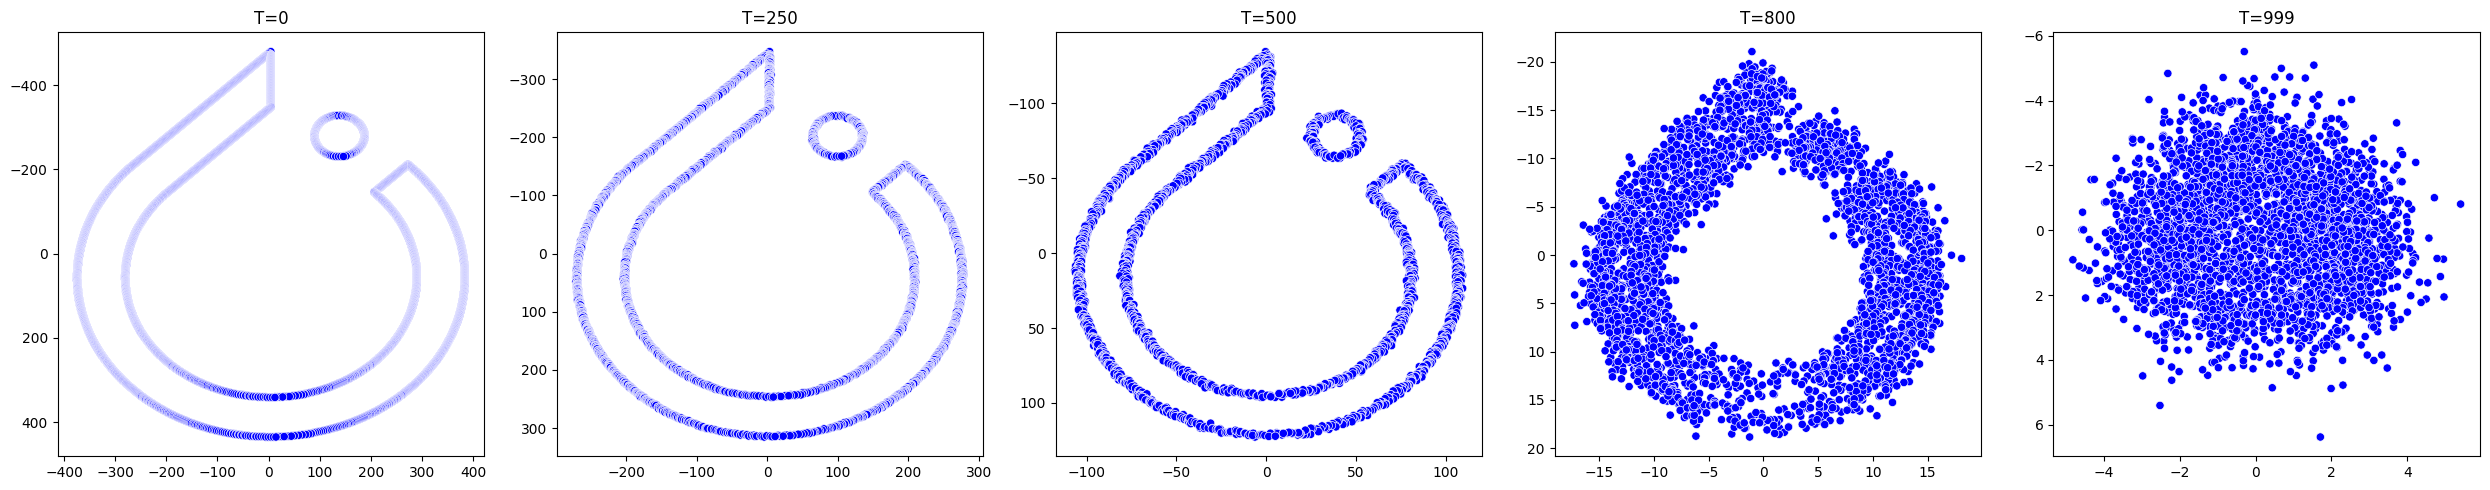

In [11]:
plot_points([x[0], x[250], x[500], x[800], x[999]], ["T=0", "T=250", "T=500", "T=800", "T=999"])

In [12]:
# Pre-calculate terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

In [13]:
def reshape_for_x(a, x):
    ones_to_broadcast = len(x.shape) - 1
    return a.view(-1, *[1] * ones_to_broadcast).to(x.device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def forward_diffusion_sample(x, t):
    x = x.to(device)
    noise = torch.randn_like(x)
    sqrt_alphas_cumprod_t = reshape_for_x(sqrt_alphas_cumprod[t], x)
    sqrt_one_minus_alphas_cumprod_t =  reshape_for_x(sqrt_one_minus_alphas_cumprod[t], x)
    # mean + variance
    return sqrt_alphas_cumprod_t * x + sqrt_one_minus_alphas_cumprod_t * noise, noise

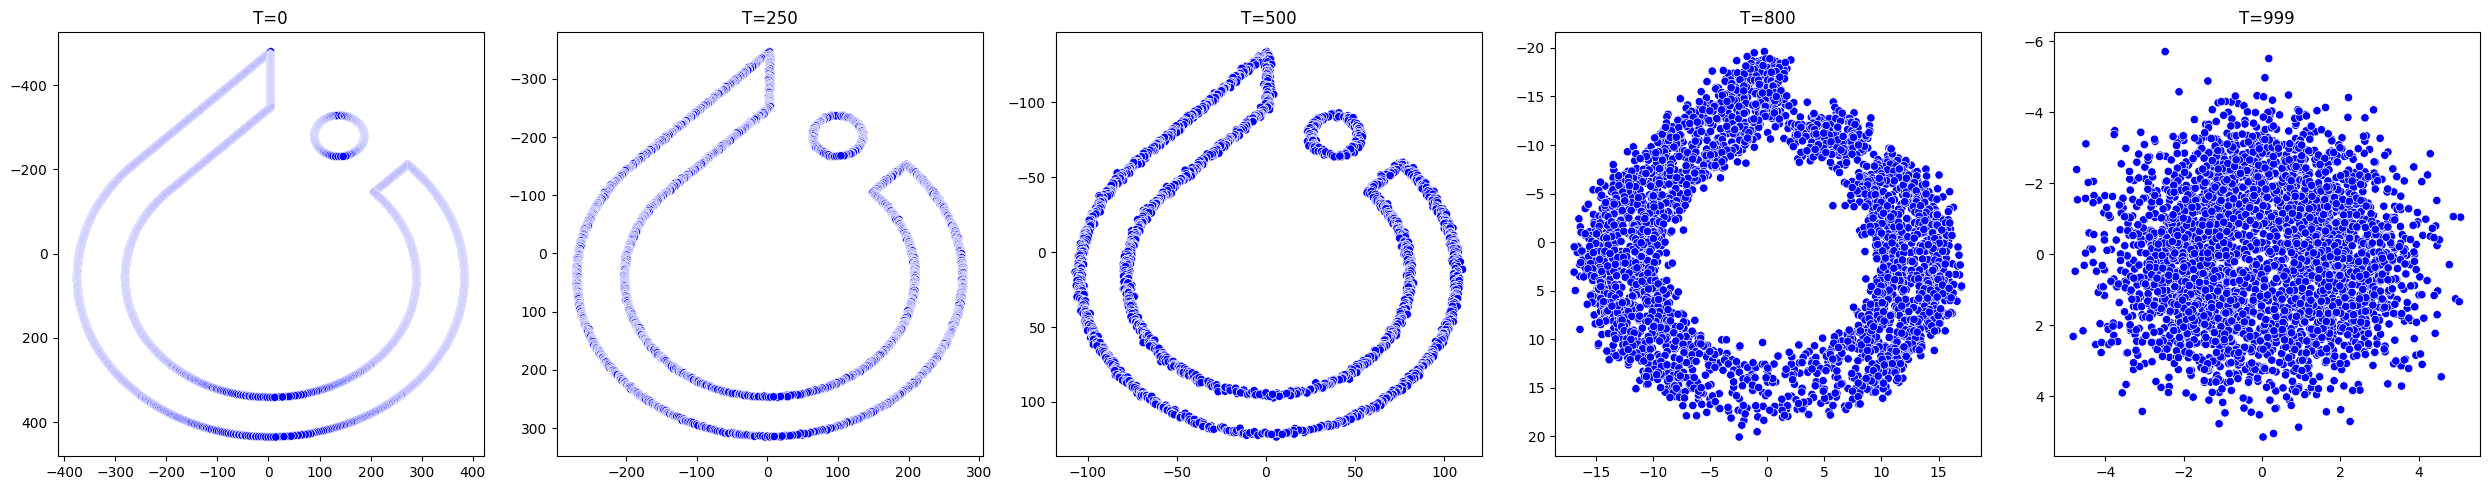

In [14]:
example_x0 = x0.clone()
example_timesteps = [0, 250, 500, 800, 999]
sample_points = []
for t in example_timesteps:
    t = torch.tensor(t).expand(example_x0.shape[0])
    new_points, _ = forward_diffusion_sample(example_x0, t)
    sample_points.append(new_points)
plot_points(sample_points, ["T=0", "T=250", "T=500", "T=800", "T=999"])